# Lab3
### Task
Write agents able to play Nim, with an arbitrary number of rows and an upper bound  on the number of objects that can be removed in a turn (a.k.a., subtraction game).  
The player taking the last object wins.  

- Task3.1: An agent using fixed rules based on nim-sum (i.e., an expert system)
- Task3.2: An agent using evolved rules
- Task3.3: An agent using minmax
- Task3.4: An agent using reinforcement learning

## Classes and functions

In [1]:
import logging
from collections import namedtuple
import random
from typing import Callable
from copy import deepcopy
from itertools import accumulate
from operator import xor, or_, and_, not_
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [2]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [3]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def k(self) -> int:
        return self._k

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

In [4]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result

def cook_status(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if state.k is None or o <= state.k]
    cooked["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    cooked["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    cooked["nim_sum"] = nim_sum(state)


    brute_force = list()
    for m in cooked["possible_moves"]:
        tmp = deepcopy(state)
        tmp.nimming(m)
        brute_force.append((m, nim_sum(tmp)))
    cooked["brute_force"] = brute_force

    return cooked

In [5]:
def pure_random(state: Nim) -> Nimply:
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

In [6]:
def evaluate(strategy1: Callable, strategy2: Callable, num_matches=100, nim_size=5) -> float:
    opponent = (strategy1, strategy2)
    won = 0

    for m in range(num_matches):
        m+=1
        nim = Nim(nim_size)
        player = random.choice([0,1])
        while nim:
            ply = opponent[player](nim)
            nim.nimming(ply)
            player = 1 - player
        if player == 1:
            won += 1
    return won / num_matches

In [7]:
def play_game(nim_size=5, strategy1=pure_random, strategy2=pure_random):   
    logging.getLogger().setLevel(logging.INFO)

    strategy = (strategy1, strategy2)

    nim = Nim(nim_size)
    logging.info(f"status: Initial board  -> {nim}")
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        logging.info(f"status: After player {player} -> {nim}")
        player = 1 - player
    winner = 1 - player
    logging.info(f"status: Player {winner} won!")
    return

In [8]:
def optimal_strategy(state: Nim) -> Nimply:
    'optimal strategy with nim sum'
    data = cook_status(state)
    return next((bf for bf in data["brute_force"] if bf[1] == 0), random.choice(data["brute_force"]))[0]

## 3.0: Let's try some basic hard-coded rules first

In [193]:
def make_strategy(genome: dict) -> Callable:
    def evolvable(state: Nim) -> Nimply:
        data = cook_status(state)
        if len([el for el in state.rows if el !=0]) == 2: #if i only have two lines left with objects
            ply = Nimply(data["longest_row"], state.rows[data["longest_row"]]-state.rows[data["shortest_row"]]) #always make lines even
        elif sum([el for el in state.rows])%2 == 1: #if the sum of the elements is odd
            for m in data["possible_moves"]:    #make a move that will make it even
                tmp=deepcopy(state)
                tmp.nimming(m)
                if sum([el for el in tmp.rows])%2  == 0:
                    ply = Nimply(m[0],m[1])
        elif random.random() < genome["p"]:
            ply = Nimply(data["shortest_row"], random.randint(1, state.rows[data["shortest_row"]]))
        else:
            ply = Nimply(data["longest_row"], random.randint(1, state.rows[data["longest_row"]]))

        return ply

    return evolvable

In [23]:
play_game(11,make_strategy({"p":0.3}), pure_random)

DEBUG:root:status: Initial board  -> <1 3 5 7 9 11 13 15 17 19 21>
DEBUG:root:status: After player 0 -> <1 3 5 7 9 11 13 15 17 19 0>
DEBUG:root:status: After player 1 -> <1 3 5 7 9 11 13 15 17 4 0>
DEBUG:root:status: After player 0 -> <1 3 5 7 9 11 13 15 17 1 0>
DEBUG:root:status: After player 1 -> <0 3 5 7 9 11 13 15 17 1 0>
DEBUG:root:status: After player 0 -> <0 3 5 7 9 11 13 15 17 0 0>
DEBUG:root:status: After player 1 -> <0 3 5 7 3 11 13 15 17 0 0>
DEBUG:root:status: After player 0 -> <0 3 5 7 3 11 13 15 12 0 0>
DEBUG:root:status: After player 1 -> <0 3 2 7 3 11 13 15 12 0 0>
DEBUG:root:status: After player 0 -> <0 3 2 7 3 11 13 13 12 0 0>
DEBUG:root:status: After player 1 -> <0 3 2 7 3 11 13 1 12 0 0>
DEBUG:root:status: After player 0 -> <0 3 2 7 3 11 7 1 12 0 0>
DEBUG:root:status: After player 1 -> <0 0 2 7 3 11 7 1 12 0 0>
DEBUG:root:status: After player 0 -> <0 0 2 7 3 11 7 1 1 0 0>
DEBUG:root:status: After player 1 -> <0 0 2 2 3 11 7 1 1 0 0>
DEBUG:root:status: After player 0

### Evaluation hard coded strategy
The two simple rules to make lines sum to an even number and to always make the last two lines contain the same number of objects allows us to win more than 90% of the matches against a random strategy and the optimal strategy.

In [14]:
print(evaluate(make_strategy({"p":0.3}),pure_random))

0.96


In [47]:
print(evaluate(make_strategy({"p":0.3}),optimal_strategy))

0.95


## 3.1: An agent using fixed rules based on nim-sum (i.e., an expert system)

In [228]:
def fixed_optimal_strategy(state: Nim) -> Nimply:
    data = cook_status(state)
    optimal_moves = [bf for bf in data["brute_force"] if bf[1] == 0]
    return random.choice(optimal_moves)[0] if len(optimal_moves) > 0 else make_strategy({"p":0.3})(state)

In [229]:
play_game(11, pure_random, fixed_optimal_strategy)

INFO:root:status: Initial board  -> <1 3 5 7 9 11 13 15 17 19 21>
INFO:root:status: After player 0 -> <1 3 5 7 9 11 13 15 16 19 21>
INFO:root:status: After player 1 -> <1 3 5 7 9 11 13 15 16 5 21>
INFO:root:status: After player 0 -> <1 3 5 7 9 11 13 15 16 0 21>
INFO:root:status: After player 1 -> <1 3 0 7 9 11 13 15 16 0 21>
INFO:root:status: After player 0 -> <1 3 0 7 9 11 13 15 16 0 3>
INFO:root:status: After player 1 -> <1 3 0 7 9 11 13 15 6 0 3>
INFO:root:status: After player 0 -> <1 3 0 7 9 8 13 15 6 0 3>
INFO:root:status: After player 1 -> <1 3 0 7 9 8 13 12 6 0 3>
INFO:root:status: After player 0 -> <1 3 0 7 9 8 13 12 2 0 3>
INFO:root:status: After player 1 -> <1 3 0 3 9 8 13 12 2 0 3>
INFO:root:status: After player 0 -> <1 3 0 3 9 8 13 4 2 0 3>
INFO:root:status: After player 1 -> <1 3 0 3 9 8 5 4 2 0 3>
INFO:root:status: After player 0 -> <1 3 0 3 9 8 5 1 2 0 3>
INFO:root:status: After player 1 -> <1 3 0 3 9 8 0 1 2 0 3>
INFO:root:status: After player 0 -> <1 3 0 3 9 8 0 0 2 0 

### Evaluation fixed strategy based on nimsum
We can evaluate the fixed strategy based on nim_sum to confirm that it wins all the matches against a random strategy. We can see here that it wins all the matches against the optimal strategy as well.

In [230]:
print(evaluate(fixed_optimal_strategy, pure_random, num_matches=200, nim_size=11))

1.0


In [231]:
print(evaluate(fixed_optimal_strategy, optimal_strategy, num_matches=200, nim_size=11))

1.0


## 3.2: An agent using evolved rules

Define a semi-optimal strategy so that I can compare the result of the ga with an algorithm that is not optimal but still very close to it.

In [9]:
def semi_optimal_strategy(state: Nim) -> Nimply:
    data = cook_status(state)
    if random.random() < 0.75:
        return next((bf for bf in data["brute_force"] if bf[1] == 0), random.choice(data["brute_force"]))[0]
    else:
        row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
        num_objects = random.randint(1, state.rows[row])
        return Nimply(row, num_objects)

In [85]:
from statistics import *

def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)

def crossover(g1,g2,problem_size):
    cut = random.randint(0, problem_size) #i have 5 rules
    return g1.genome[:cut] + g2.genome[cut:]

def mutation(g, problem_size):
    point = random.randint(0, problem_size-1)
    return g[:point] + [1 - g[point]] + g[point + 1 :]

def initialize_population():
    return 

def my_and(rows: tuple) -> int:
    *_, result = accumulate(rows, and_)
    return result

def my_or(rows: tuple) -> int:
    *_, result = accumulate(rows, or_)
    return result

RULES = [sum, min, stdev, my_and, my_or]

def evolvable_strategy(genome):
    def strategy(state: Nim):
        candidate_plays = list()
        data=cook_status(state)
        possible_moves = data["possible_moves"]
        for m in possible_moves:
            tmp = deepcopy(state)
            tmp.nimming(m)
            play = (m, sum(w * op(tmp.rows) for w, op in zip(genome, RULES)))
            candidate_plays.append(play)
            if play[1] == 0:
                return play[0]                                
        return min(candidate_plays, key=lambda x: x[1])[0]
    return strategy

def fitness(genome):
    'fitness with semi-optimal strategy'
    return (evaluate(evolvable_strategy(genome),semi_optimal_strategy,num_matches=10) , evaluate(evolvable_strategy(genome),pure_random,num_matches=10))

In [89]:
def genetic_algorithm(rules: list, fixed=True):
    Individual = namedtuple('Individual',('genome','fitness'))
    NUM_GENERATIONS = 100
    POPULATION_SIZE = 10
    OFFSPRING_SIZE = 5
    problem_size=len(rules)

    #Variables initialization
    plateau_count = 0 #stores the number of consecutive generations in which the algorithm does not improve
    #Initialize population
    population = [Individual(i, fitness(i)) for i in ([random.choice([0,1]) for _ in range(len(RULES))] for _ in range(POPULATION_SIZE))]

    #Create fitness log
    fitness_log = [(0, i.fitness) for i in population]

    prob_vett = [0.3,0.5,0.7]
    
    #Evolution algorithm
    for g in range(NUM_GENERATIONS):
        offspring = list()
        for i in range(OFFSPRING_SIZE):
            #decide the probability of crossover/mutation
            if fixed: prob=0.3
            elif g//10 > 2: #if fixed=False increase the probabiliy of mutation every 10 generations
                prob=0.7
            else: prob=prob_vett[g//10]
            if random.random() < prob:
                p = tournament(population)
                o = mutation(p.genome,problem_size)
            else:
                p1 = tournament(population)
                p2 = tournament(population)
                o = crossover(p1, p2, problem_size)
            f = fitness(o)
            fitness_log.append((g + 1, f))
            offspring.append(Individual(o, f))
        population += offspring
        population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE]
        #check if we have reached a plateau, if we don't improve for 20 generations break
        if max(f[1] for f in fitness_log if f[0] == g + 1) <= max(f[1] for f in fitness_log if f[0] == g): plateau_count += 1
        else: plateau_count = 0
        if plateau_count == 20: break 
    logging.info(f"The best individual is: {population[0]}")
    return evolvable_strategy(population[0].genome)


In [87]:
logging.getLogger().setLevel(logging.INFO)
final_strategy = genetic_algorithm(RULES)
print(final_strategy)

INFO:root:The best individual is: Individual(genome=[0, 1, 0, 1, 1], fitness=(0.9, 0.7))


<function evolvable_strategy.<locals>.strategy at 0x0000021C2B042CA0>


In [88]:
print(evaluate(final_strategy,pure_random))
print(evaluate(final_strategy,semi_optimal_strategy))
print(evaluate(final_strategy,optimal_strategy))

0.84
0.47
0.0


## 3.3: An agent using minmax
For this agent we use the minmax tecnique with alpha-beta pruning and (possibly) a maximum bound. To improve the performance in terms of computation time we also save the states and their scores in a cache so that if the search comes across a state already seen it can just use the information saved in the cache.  
To avoid creating a new cache every time we play a game, we save in different files the caches corresponding to different nim_sizes using pickle. This way if we have played one game we don't have to generate the cache again because we can just load it and play. Saving and loading caches will save us a large amount of time especially for bigger nim_size: for example with nim_size=7 we can play a game in under two seconds. Furthermore generating the cache only once allows us to play without a bound for a bigger N since we only have to play once to create the cache.

In [9]:
def get_move(state1: Nim, state2: Nim) -> Nimply:
    diff=[a-b for a,b in zip(state1.rows, state2.rows)]
    row=[index for index, el in enumerate(diff) if el!=0][0]
    num_objects=abs(diff[row])
    return Nimply(row, num_objects)

def possible_new_states(state: Nim):
    data=cook_status(state)
    possible_new_states = list()
    for move in data["possible_moves"]:
        tmp=deepcopy(state)
        tmp.nimming(move)
        possible_new_states.append(tmp)                    
    return possible_new_states

In [10]:
def minmax(state: Nim, maximizing, alpha=-1, beta=1, bound=5, depth=0):
    global cache, hits, misses, use_bound
    MAX_CACHE_LENGTH = 1e7

    def eval(state: Nim, maximizing):
        if sum(state.rows) == 0 or (use_bound==True and depth>=bound):
            return -1 if maximizing else 1

    if (score := eval(state, maximizing)) is not None:
        return score

    scores = list()
    for new_state in possible_new_states(state):
        item = (new_state.rows, not maximizing, alpha, beta)
        if item not in cache or len(cache) > MAX_CACHE_LENGTH:
            misses += 1
            score = minmax(state=new_state, alpha=alpha, beta=beta, maximizing=not maximizing, depth=depth+1)
            scores.append(score)
            cache.update({item: score})
        else:
            hits += 1
            score = cache[item]
            scores.append(score)
        if maximizing:
            alpha = max(alpha, score)
        else:
            beta = min(beta, score)
        if beta <= alpha:
            break
    return (max if maximizing else min)(scores)

def minmax_strategy(state: Nim):
    tmp=deepcopy(state)
    for new_state in possible_new_states(state):
        score = minmax(new_state, maximizing=False)
        if score > 0:
            break
    return get_move(new_state,tmp)

In [11]:
def save_cache(cache: dict, nim_size: int):
    filename = "cache_" + str(nim_size)
    data = open(filename,'wb')
    pickle.dump(cache, data)
    data.close()
    return

def load_cache(nim_size: int):
    filename = "cache_" + str(nim_size)
    data = open(filename,'rb')
    x = pickle.load(data)
    data.close()
    return x

In [ ]:
logging.disable(logging.CRITICAL)
nim_sizes = [3,4,5,6,7]
for size in nim_sizes:
    hits = 0
    misses = 0
    cache = {}
    use_bound = False
    play_game(size, minmax_strategy, pure_random)
    save_cache(cache, size)
    print(f"Cache for nim_size={size} saved")

Cache for nim_size=3 saved
Cache for nim_size=4 saved
Cache for nim_size=5 saved
Cache for nim_size=6 saved
Cache for nim_size=7 saved


Now that we have saved the caches for nim_size up to 7 we can play a much faster game using minmax. We just need to upload the cache corrisponding to the dimension we want to play with. Example for nim_size=7:

In [34]:
logging.disable(logging.NOTSET)
logging.getLogger().setLevel(logging.INFO)
nim_size = 7
hits = 0
misses = 0
cache = load_cache(7)
use_bound = False
play_game(nim_size, minmax_strategy, pure_random)
print(hits)

INFO:root:status: Initial board  -> <1 3 5 7 9 11 13>
INFO:root:status: After player 0 -> <1 3 5 7 6 11 13>
INFO:root:status: After player 1 -> <1 1 5 7 6 11 13>
INFO:root:status: After player 0 -> <1 1 5 5 6 11 13>
INFO:root:status: After player 1 -> <0 1 5 5 6 11 13>
INFO:root:status: After player 0 -> <0 0 5 5 6 11 13>
INFO:root:status: After player 1 -> <0 0 5 5 0 11 13>
INFO:root:status: After player 0 -> <0 0 3 5 0 11 13>
INFO:root:status: After player 1 -> <0 0 3 5 0 3 13>
INFO:root:status: After player 0 -> <0 0 3 5 0 3 5>
INFO:root:status: After player 1 -> <0 0 3 5 0 3 3>
INFO:root:status: After player 0 -> <0 0 3 3 0 3 3>
INFO:root:status: After player 1 -> <0 0 3 3 0 0 3>
INFO:root:status: After player 0 -> <0 0 0 3 0 0 3>
INFO:root:status: After player 1 -> <0 0 0 3 0 0 1>
INFO:root:status: After player 0 -> <0 0 0 1 0 0 1>
INFO:root:status: After player 1 -> <0 0 0 1 0 0 0>
INFO:root:status: After player 0 -> <0 0 0 0 0 0 0>
INFO:root:status: Player 0 won!


880


### Evaluation minmax strategy
About the bound: if we use the cache saved in the files we can play with or without the bound and the results won't change. This is because the depth in the minmax algorithm increases only when we have a miss in the cache but using the saved cache we will not have any misses.  
It is more convenient in terms of time to load and visit the saved cache than to create it from scratch and use the bound. Of course for nim_size greater than 7 it becomes very difficult to play even one game without using the bound, so for bigger problems we would need to use it.

In [18]:
#the minmax strategy wins all the games against a random strategy using the saved cache (or without bound)
cache = load_cache(5)
use_bound = True
evaluate(minmax_strategy,pure_random,num_matches=100,nim_size=5)

1.0

In [33]:
#the minmax strategy wins about half of the games against the optimal strategy (depending on which player starts)
cache = load_cache(5)
use_bound = True
print(evaluate(minmax_strategy,optimal_strategy,num_matches=100,nim_size=5))

0.54


## 3.4: An agent using reinforcement learning
This tecnique shows an agent training with reinforcement learning against the optimal strategy defined for task 3.2.
Unfortunately this method is very game-specific: we need to train a different agent for every nim_size. For the purpose of this lab we will use nim_size = 5 both for training and testing.  
WARNING: if we use random.random() instead of the fixed value 0.1 in G.update the algorithm can not win against the optimal (not even one game in 4000).

In [9]:
global G
G = dict()

def choose_move(state: Nim, random_factor: float): #random_factor needs to be 0 after training to choose the best move
    data = cook_status(state)
    allowed_moves = data['possible_moves']
    maxG = -10e15
    next_move = None
    randomN = random.random()
    if randomN < random_factor:
        #if random number below random factor, choose random action
        next_move = random.choice(list(allowed_moves))
        new_state = deepcopy(state)
        new_state.nimming(next_move)
        G.update({new_state.rows: 0.1 }) if new_state not in G else None
    else:
        #if exploiting, chose the action with the highest reward
        for move in allowed_moves:
            new_state = deepcopy(state)
            new_state.nimming(move)
            G.update({ new_state.rows: 0.1 }) if new_state not in G else None
            if G[new_state.rows] >= maxG:
                next_move = move
                maxG = G[new_state.rows]
    return next_move

def learn(states_history: list, random_factor: float, learning_rate: float):
        target = 0
        for prev, reward in reversed(states_history):
            G[prev] = G[prev] + learning_rate * (target - G[prev])
            target += reward
        random_factor -= 10e-5
        return random_factor

In [10]:
def reinforcement_learning(initial_state: Nim, epochs: int, random_factor: float, learning_rate: float, depth: int = 0, player = 0, plot_wins=True):
    states_history = list()
    winsHistory = list()
    epochs_num = list()
    wins = 0
    current_state = deepcopy(initial_state)
    for i in range(epochs):
        player = random.choice([0,1])
        while sum(current_state.rows) != 0 : #while the game is still going (no one has won yet)
            if not player:
                move = optimal_strategy(current_state)
                tmp = deepcopy(current_state)
                tmp.nimming(move)
                if sum(tmp.rows)==0:
                    #i need to give the current state a negative reward, the opponent has won
                    states_history.pop() #remove the last state because it has reward=0 and I want to associate -1 to that state
                    states_history.append((deepcopy(current_state).rows, -1))
                current_state.nimming(move)
            else: 
                move = choose_move(deepcopy(current_state), random_factor)
                current_state.nimming(move)  
                reward = 0 if sum(current_state.rows)!=0 else 1
                if reward == 1 : wins+=1
                depth += 1 #at the end depth contains the number of moves to win this game
                states_history.append((deepcopy(current_state).rows, reward))
            player = 1 - player
        random_factor= learn(states_history, random_factor, learning_rate)  
        states_history = list()
        if i % 50 == 0:
            winsHistory.append(100*wins/(i+1)) #save percentage of won games
            epochs_num.append(i)
        current_state = deepcopy(initial_state)
        depth = 0
    
    if plot_wins: 
        plt.semilogy(epochs_num, winsHistory, "b")
        plt.xlabel('epochs')
        plt.ylabel('won games %')
    return winsHistory

def reinforcement_learning_strategy(state: Nim, random_factor: float=0):
    best_move = choose_move(state, random_factor)
    return best_move

Here we show some preliminary results

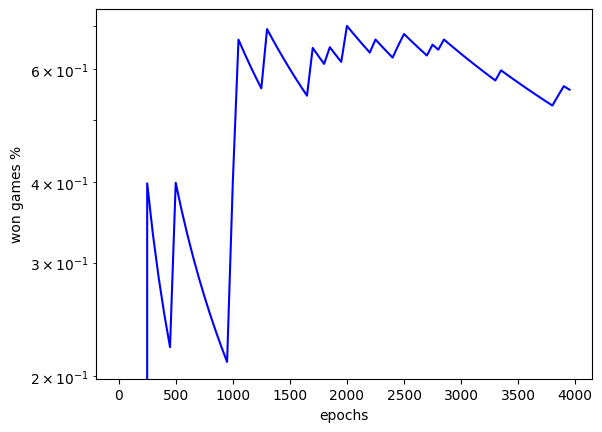

In [11]:
logging.getLogger().setLevel(logging.INFO)
initial_state = Nim(5)
G = dict()
r = reinforcement_learning(initial_state=initial_state, epochs=4000, random_factor=0.2, learning_rate=0.25)
#the plot shows the percentage of games won during the training

In [185]:
evaluate(reinforcement_learning_strategy, pure_random, 200, 5)

0.61

### Learning rate and random factor tuning
We perform a parameter tuning on the random factor and the learning rate with nim_size = 5 and we increase the training epochs to 10000. We chose the best performance against the random strategy even if we train against the optimal. This choice is driven by the observation that the number of wins against the optimal always stays under 5% so we prefer to evaluate the performance against the random.

((0.3, 0.7), 0.655)


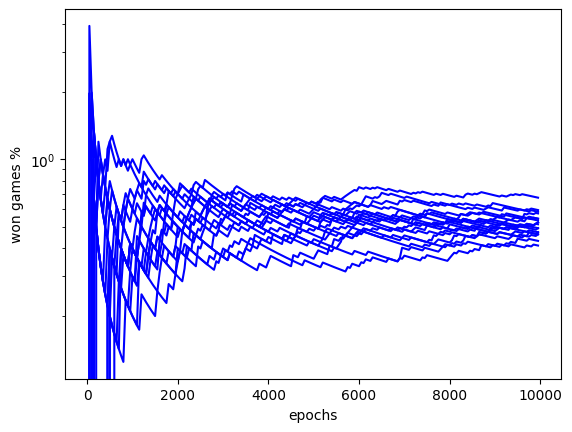

In [12]:
random_factors = [0.1, 0.2, 0.3]
learning_rates = [0.1, 0.3, 0.5, 0.7, 1, 10]
results = dict()
nim_size = 5
for rf in random_factors:
    for lr in learning_rates:
        reinforcement_learning(initial_state=Nim(nim_size), epochs=10000, random_factor=rf, learning_rate=lr)
        results[(rf,lr)] = evaluate(reinforcement_learning_strategy, pure_random, 200, nim_size)
best_parameters = max(results.items(), key= lambda x:x[1])
print(best_parameters)

The picture above shows that unfortunately changing the learning rate and the random factor does not bring any relevant change to the training. This will be confirmed by the next results which are very similar to those obtained before without the tuning.
This aspect should definitely be looked into...  
Now we train the agent again using the best parameters found in the tuning and we evaluate the results.

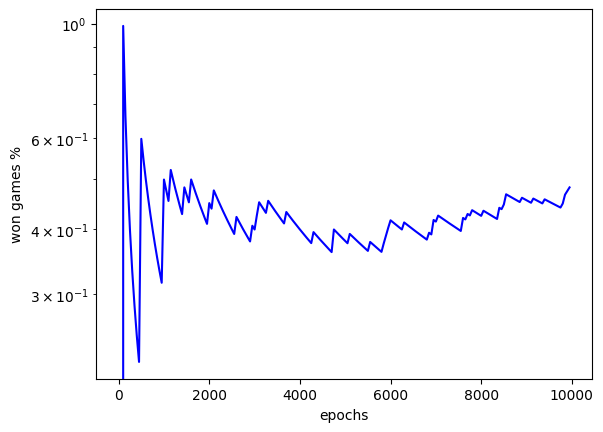

In [14]:
logging.getLogger().setLevel(logging.INFO)
initial_state = Nim(5)
G = dict()
r = reinforcement_learning(initial_state=initial_state, epochs=10000, random_factor=best_parameters[0][0], learning_rate=best_parameters[0][1])

In [156]:
evaluate(reinforcement_learning_strategy, pure_random, 200, 5)

0.61

In [162]:
evaluate(reinforcement_learning_strategy, optimal_strategy, 200, 5)

0.01

In [163]:
evaluate(reinforcement_learning_strategy, semi_optimal_strategy, 200, 5)

0.19